In [48]:
import numpy as np
import torch

In [49]:
from models import MPS, ComplexTensor

In [50]:
L=2
local_dim=2
bond_dim=2

In [51]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [71]:
fname_settings="datasets/settings_ghz_plus_random_basis_L=%d.npy" %L
fname_samples="datasets/samples_ghz_plus_random_basis_L=%d.npy" %L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [72]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [73]:
from qtools import pauli_exp

In [74]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [75]:
from torch.utils.data import TensorDataset, DataLoader

In [76]:
from models import MeasurementDataset, ComplexTensor

In [77]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [78]:
batch_size = 64
lr = .001

In [79]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [80]:
losses = []

In [81]:
eps = 20

In [82]:
def sgd_step_at_site(mps, site_index, spin_config,
                         rotation=None, cutoff=1e-10, normalize='left', 
                        max_sv_to_keep=None):
    """Perform SGD step WRT two-site blob with left index at the site specified"""
    psi.gauge_to(site_index)
    #two-site blob matrix at the site
    A = psi.merge(i).numpy()
    #gradient of the log-prob WRT that complex matrix
    #note that A has to updated from the conjugate!
    g=psi.grad_twosite_logprob(i, spin_config,rotation=rotation).numpy().conj()
    #perform gradient descent step, insert back into MPS
    A = A - 2 * lr * g
    psi.set_sites_from_twosite(i, A,cutoff=cutoff,normalize=normalize, max_sv_to_keep=max_sv_to_keep)
   

In [83]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        for i in range(L-1):
            sgd_step_at_site(psi, i, spinconfig,
                                    rotation=rotations,cutoff=1e-10,normalize='left',max_sv_to_keep=None)   
        for i in range(L-2, -1,-1):
            sgd_step_at_site(psi, i, spinconfig,
                                 rotation=rotations, cutoff=1e-10,normalize='right',max_sv_to_keep=None)
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4
finished epoch 5
finished epoch 6
finished epoch 7
finished epoch 8
finished epoch 9
finished epoch 10
finished epoch 11
finished epoch 12
finished epoch 13
finished epoch 14
finished epoch 15
finished epoch 16
finished epoch 17
finished epoch 18
finished epoch 19


In [84]:
import matplotlib.pyplot as plt

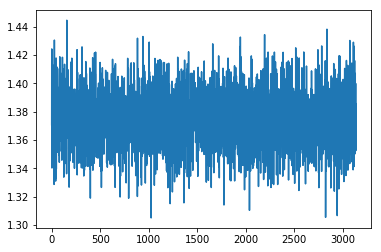

In [85]:
%matplotlib inline
plt.plot(losses)

In [86]:
print(psi.shape)

[(1, 2), (2, 1)]


In [87]:
from tools import generate_binary_space

In [88]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [89]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1]) has probability 0.2093
tensor([1, 0]) has probability 0.2785
tensor([0, 1]) has probability 0.3234
tensor([0, 0]) has probability 0.1889
